# **Data Mining and Machine Learning 2020** - Final project - Team OMEGA
## Real or Not? Natural Language Processing with Disaster Tweets.

Twitter has become an important communication channel in times of emergency. But it is not always clear whether a person is communicating about the real distater or not. We try to predict whether a tweet is about a real disaster or is a simple metaphor. 

1. EDA 
2. Pre-processing
3. Building models

    *   Synthesis
    *   Logistic Regression
    *   KNN
    *   Decision Tree
    *   Random Forest

4. Conclusion


Loading needed packages:

In [81]:
%%time
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import re
import sklearn
from sklearn.preprocessing import StandardScaler
import string
import spacy
!python -m spacy download en
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import time
import string
sns.set_style("white")
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
CPU times: user 27.9 ms, sys: 14.1 ms, total: 42 ms
Wall time: 3.57 s


Loading and displaying data:


In [2]:
df_train= pd.read_csv("https://raw.githubusercontent.com/DM-omega/Omega/main/Data/82653de5-2ed1-4782-959e-23eba75d67a9_training_data.csv")
df_test= pd.read_csv("https://raw.githubusercontent.com/DM-omega/Omega/main/Data/test_data.csv")
df_train_1 = df_train
df_train

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,NaN,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


Important: we are using two train sets - one where we use a 80/20 split and the other not.

In [3]:
df_test

,id,keyword,location,text
0,9972,tsunami,NaN,Crptotech tsunami and banks.\n http://t.co/KHz...
1,9865,traumatised,"Portsmouth, UK",I'm that traumatised that I can't even spell p...
2,1937,burning%20buildings,NaN,@foxnewsvideo @AIIAmericanGirI @ANHQDC So ... ...
3,3560,desolate,NaN,Me watching Law &amp; Order (IB: @sauldale305)...
4,2731,crushed,bahstun/porta reeko,Papi absolutely crushed that ball
...,...,...,...,...
1137,3497,derailed,NaN,@ItsQueenBaby I'm at work it's a bunch of ppl ...
1138,9191,suicide%20bomber,NaN,#?? #?? #??? #??? Suicide bomber kills 15 in S...
1139,10217,volcano,NaN,Eruption of Indonesian volcano sparks transpor...
1140,5308,fear,New York,Never let fear get in the way of achieving you...


## 1. EDA


---


In this part of the notebook, we will describe our target variable, its distribution and other interesting properties. This is done in order to understand what steps need to be taking while pre-processing.

Shape of sets:

In [5]:
print('Training Set Shape = {}'.format(df_train.shape))

Training Set Shape = (6471, 5)


In [6]:
print('Test Set Shape = {}'.format(df_test.shape))

Test Set Shape = (1142, 4)


Test set has one less feature - it doesn't have a disaster label.

### Distribution of the target variable


---

In our case, our target variable is a binary variable. It takes value ==  if a tweet is a bout a real distater; 0 otherwise. In our train test, we have already labeled data.

In our set, we have about not very distorted distribution of a target variable:

In [7]:
df_train.target.value_counts()

0    3701
1    2770
Name: target, dtype: int64

Сomputing baserate of the problem confirms it:


In [8]:
base_rate = len(df_train[df_train["target"] == 0])/len(df_train)
print(base_rate)

0.5719363313243703


To represent it graphically:

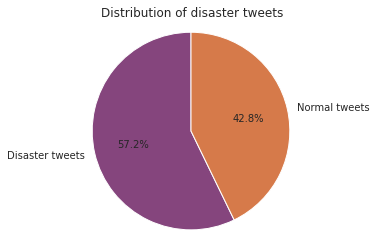

In [64]:
labels = 'Disaster tweets','Normal tweets'
sizes = [base_rate, 1-base_rate]
colors = [(0.52, 0.27, 0.49), (0.84, 0.48, 0.29)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors = colors)
ax1.axis('equal')

ax1.set_title("Distribution of disaster tweets")
plt.show()

We also wanted to see whether it the number of characters in the tweets influences the predicting ability, but we didn't see a significant change.

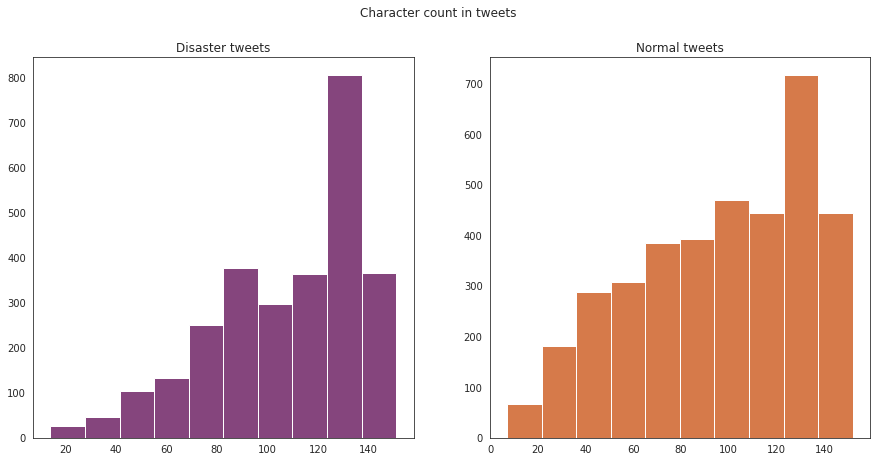

In [62]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7))
tweet_len=df_train[df_train['target']==1]['text'].str.len()
ax1.hist(tweet_len, color = [(0.52, 0.27, 0.49)])
ax1.set_title('Disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.len()
ax2.hist(tweet_len, color = [(0.84, 0.48, 0.29)])
ax2.set_title('Normal tweets')
fig.suptitle('Character count in tweets')
plt.show()

### Analysis of other features

---

Let's see how many null observations we have for both train and test sets:

In [12]:
df_train.isnull().sum()

id             0
keyword       55
location    2141
text           0
target         0
dtype: int64

In [13]:
df_test.isnull().sum()

id            0
keyword       6
location    392
text          0
dtype: int64

In a train set, we see that location is missing in 2141 cases of 6471, giving 33% of a missing data in this feature. Location is a hand inputed by the user and doesn't have any conformity, therefore it cannot be used for predicting a target variable. 

Let's see how many unique **locations** are present in datasets.

In [14]:
location_train = df_train["location"].nunique()
location_test = df_test["location"].nunique()
print("There are", location_train, 'unique locations in train set')
print("There are", location_test, 'unique locations in test set')

There are unique 2921 locations in train test
There are unique 632 locations in test test


Location is a hand inputed by the user and doesn't have any conformity, therefore it cannot be used for predicting a target variable. 

These are 20 most popular locations:

In [16]:
df_train['location'].value_counts().head(20)

USA                 91
New York            59
United States       46
London              39
Canada              25
UK                  24
Los Angeles, CA     23
Nigeria             22
India               21
Washington, DC      20
Mumbai              20
Australia           17
Kenya               16
Chicago, IL         15
Worldwide           14
California          14
Everywhere          14
United Kingdom      13
Washington, D.C.    13
New York, NY        13
Name: location, dtype: int64

Displaying 10 most popular locations:

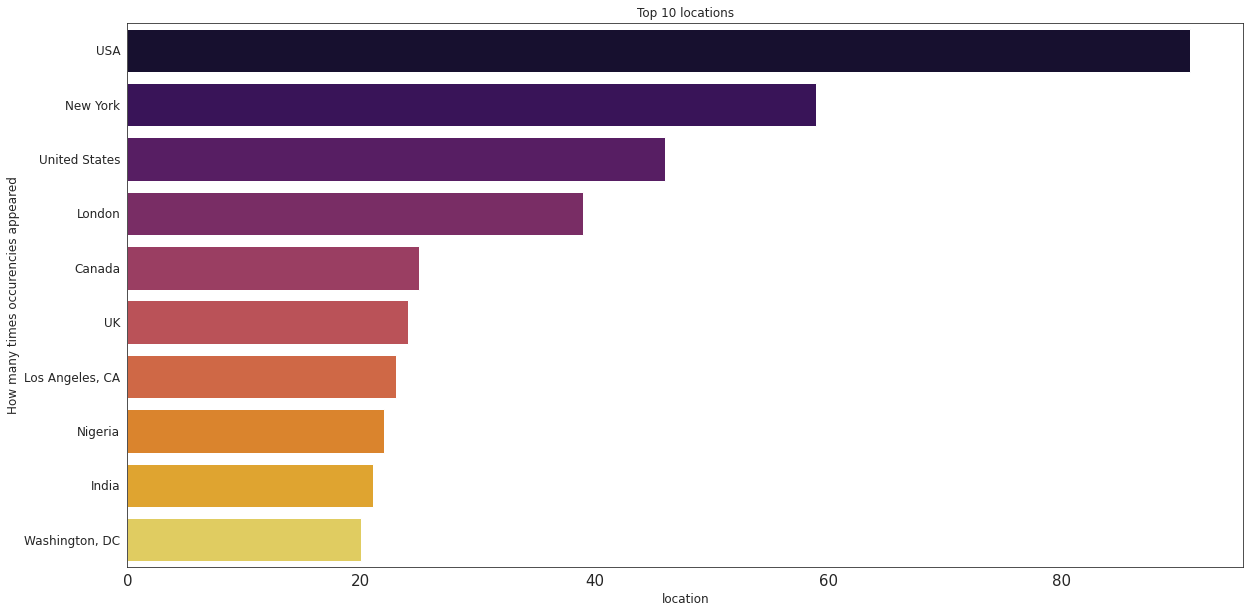

In [18]:
location_count = df_train['location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(20,10))
sns.barplot(y = location_count.index, x = location_count.values, palette= 'inferno')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.title('Top 10 locations')
plt.ylabel('How many times occurencies appeared', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()

We have our confirmation that locations are not uniform: USA is not replaced by United States, or vice verse. We can see that most of these locations are part of US (5/10)

Let perform the same test on test set: 

In [19]:
df_test['location'].value_counts().head(20)

USA                  13
New York             12
London                6
Nigeria               6
Worldwide             5
Chicago               4
Kenya                 4
United States         4
Canada                4
Ireland               4
Singapore             3
??????                3
Chicago, IL           3
South Africa          3
UK                    3
Las Vegas, Nevada     3
Los Angeles, CA       3
Scotland              3
Newcastle             3
California            3
Name: location, dtype: int64

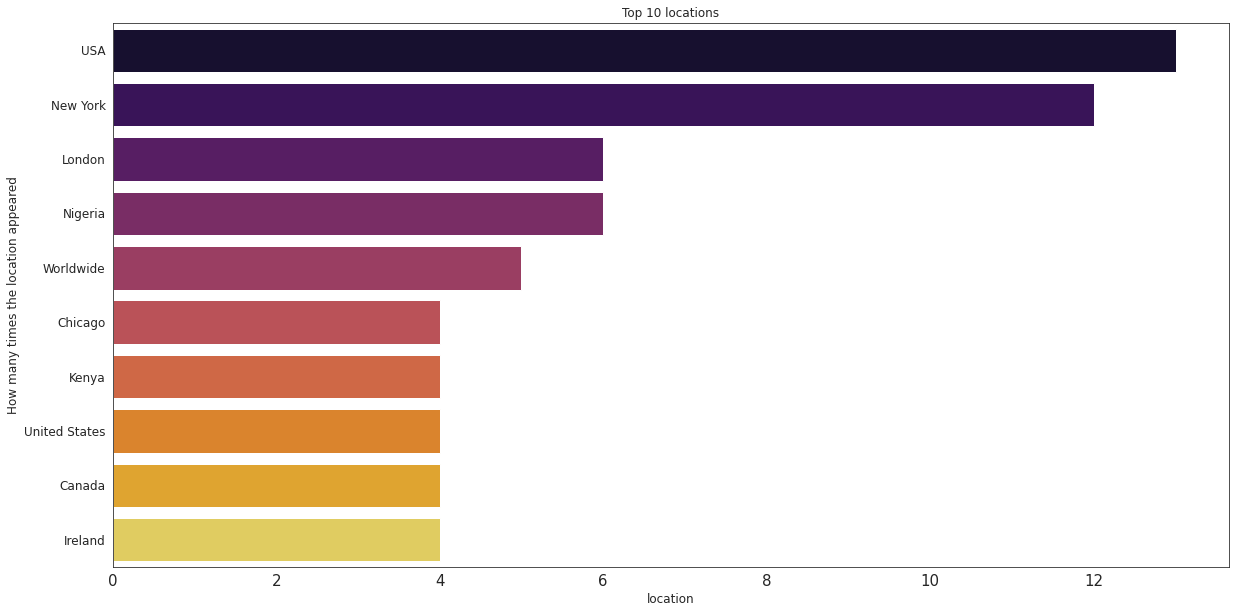

In [20]:
location_count  = df_test['location'].value_counts()
location_count = location_count[:10,]
plt.figure(figsize=(20,10))
sns.barplot(y = location_count.index, x = location_count.values, palette= 'inferno') # alpha=0.8)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.title('Top 10 locations')
plt.ylabel('How many times the location appeared', fontsize=12)
plt.xlabel('location', fontsize=12)
plt.show()

US is still leading in the top locations, but other countries appeared as well.

---
Let's analyze the feature **keyword**

In [25]:
keyword_train = df_train["keyword"].nunique()
keyword_test = df_test["keyword"].nunique()
print("There are", keyword_train, 'unique keywords in train set')
print("There are", keyword_test, 'unique keywords in test set')

There are 221 unique keywords in train test
There are 220 unique keywords in test test


In [38]:
df_train['keyword'] = df_train['keyword'].str.replace('%20',' ')
print("The most popular keywords in train set:")
print(df_train['keyword'].value_counts().head(15))

The most popular keywords in train set:
deluge        39
earthquake    38
collision     37
harm          37
fatalities    36
collided      36
sinking       36
hostages      36
siren         36
ambulance     36
fear          35
destroy       35
twister       35
outbreak      35
weapons       35
Name: keyword, dtype: int64


These are the most important keywords in a train set, but what about keywords representing a real distater?

In [39]:
df_train.loc[df_train['target'] == 1, ['keyword']].value_counts().head(15)

keyword         
outbreak            35
wreckage            34
derailment          33
typhoon             32
debris              32
oilspill            30
earthquake          29
razed               28
nucleardisaster     28
rescuers            27
collision           27
suicidebomber       27
wildfire            26
airplaneaccident    26
suicidebombing      26
dtype: int64

Let's see target distribution by keyword:

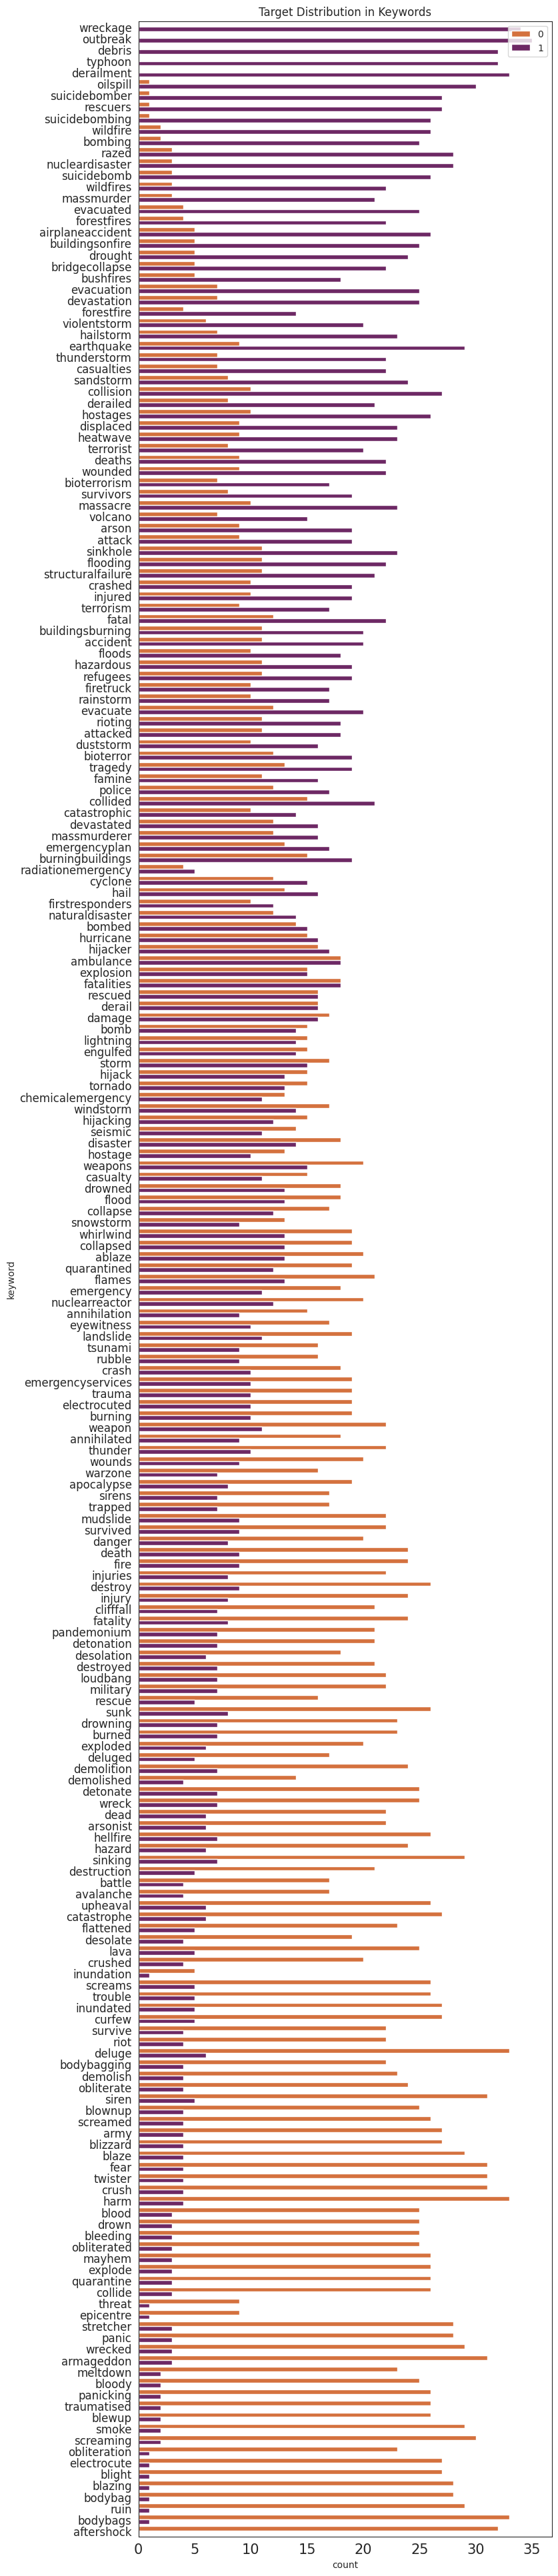

In [40]:
df_train['target_m'] = df_train.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(8, 50), dpi=100)

y=df_train.sort_values(by='target_m', ascending=False)['keyword']
hue=df_train.sort_values(by='target_m', ascending=False)['target']

sns.countplot(y=df_train.sort_values(by='target_m', ascending=False)['keyword'], 
              hue=df_train.sort_values(by='target_m', ascending=False)['target'], palette = 'inferno_r')

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_m'], inplace=True)

In [34]:
df_test['keyword'] = df_test['keyword'].str.replace('%20',' ')
print("The most popular keywords in test set:")
print(df_test['keyword'].value_counts().head(15))

The most popular keywords in test set:
desolation           12
famine               12
demolished           10
duststorm            10
derailed              9
bombed                9
avalanche             9
tsunami               9
explosion             9
fatalities            9
chemicalemergency     9
massmurder            9
explode               9
windstorm             9
pandemonium           9
Name: keyword, dtype: int64


In [65]:
tr1_df = df_train[df_train["target"]==1]
tr0_df = df_train[df_train["target"]==0]
gr_1 = tr1_df['location'].value_counts()
gr_1.reset_index()
gr_1 = gr_1[:20,]

gr_0 = tr0_df['location'].value_counts()
gr_0.reset_index()
gr_0 = gr_0[:20,]

trace1 = go.Bar(
                x = gr_1.index,
                y = gr_1.values,
                name = "Real distater tweets location wise",
                marker = dict(color = 'rgb(132, 68, 124)',
                             line=dict(color='rgb(0,0,0)')),
                )
trace0 = go.Bar(
                x = gr_0.index,
                y = gr_0.values,
                name = "Other tweets location wise",
                marker = dict(color = 'rgb(214, 123, 75)',
                             line=dict(color='rgb(0,0,0)')),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

## 2. Cleaning the data


---

Since we are going to analyse the **text** feature representing a tweet, we will need to pre-process it to remove the noise. 

First, we will replace the N/A with "?"

In [66]:
df_train = df_train.fillna('?')
df_test = df_test.fillna('?')
df_train_1 = df_train_1.fillna('?')
df_train

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,?,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1
6467,3408,derail,?,@EmiiliexIrwin Totally agree.She is 23 and kno...,0
6468,9794,trapped,?,Hollywood Movie About Trapped Miners Released ...,1
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1


Second, we saw that the keywords were repeating and provided good description about a tweet. So, we decided to add the keywords to the tweet texts. This improved our accuracy and TF-IDF recognised the term frequencies across all the tweets and gave it the needed importance. 

In [67]:
df_train["text"] = df_train["keyword"].str.cat(df_train["text"],sep=" ")
df_train_1["text"] = df_train_1["keyword"].str.cat(df_train_1["text"],sep=" ")
df_test["text"] = df_test["keyword"].str.cat(df_test["text"],sep=" ")

To display the concatenation:

In [69]:
df_train['text']

0       destroyed Black Eye 9: A space battle occurred...
1       bioterror #world FedEx no longer to transport ...
2       windstorm Reality Training: Train falls off el...
3       hazardous #Taiwan Grace: expect that large roc...
4       hostage New ISIS Video: ISIS Threatens to Behe...
                              ...                        
6466    earthquake #Earthquake #Sismo M 1.9 - 15km E o...
6467    derail @EmiiliexIrwin Totally agree.She is 23 ...
6468    trapped Hollywood Movie About Trapped Miners R...
6469    weapons Friendly reminder that the only countr...
6470    buildingsonfire Buildings are on fire and they...
Name: text, Length: 6471, dtype: object

We proceed further dans le pre-processing, and we clean the URLs: 

In [ ]:
def cleaning(text):
    text = str(text).lower()
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df_train['text']=df_train['text'].apply(lambda x : cleaning(x))
df_train_1['text']=df_train_1['text'].apply(lambda x : cleaning(x))
df_test['text']=df_test['text'].apply(lambda x : cleaning(x))
df_train

,id,keyword,location,text,target
0,3738,destroyed,USA,destroyed black eye 9: a space battle occurred...,0
1,853,bioterror,?,bioterror #world fedex no longer to transport ...,0
2,10540,windstorm,"Palm Beach County, FL",windstorm reality training: train falls off el...,1
3,5988,hazardous,USA,hazardous #taiwan grace: expect that large roc...,1
4,6328,hostage,Australia,hostage new isis video: isis threatens to behe...,1
...,...,...,...,...,...
6466,4377,earthquake,ARGENTINA,earthquake #earthquake #sismo m 1.9 - 15km e o...,1
6467,3408,derail,?,derail @emiiliexirwin totally agree.she is 23 ...,0
6468,9794,trapped,?,trapped hollywood movie about trapped miners r...,1
6469,10344,weapons,Beirut/Toronto,weapons friendly reminder that the only countr...,1


We proceed with SPACY to use the english dictionary. We then proceed with a tokenizer for lowering all the characters, removing punctuations, removing numbers and lemmatizing words.

In [71]:
sp = spacy.load('en_core_web_sm')
punctuations = string.punctuation
numbers = "0123456789"

def spacy_tokenizer(sentence):
    mytokens = sp(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in punctuations and not word.isnumeric()]
    return mytokens

print(df_train['text'].iloc[0])
print(spacy_tokenizer(df_train['text'].iloc[0]))

destroyed Black Eye 9: A space battle occurred at Star O784 involving 3 fleets totaling 3945 ships with 17 destroyed
['destroy', 'black', 'eye', 'a', 'space', 'battle', 'occur', 'at', 'star', 'o784', 'involve', 'fleet', 'total', 'ship', 'with', 'destroy']


We found that too much of preprocessing would lower our accuracy. Also, we noticed that removing stop words would also lower our accuracy, therefore we didn't remove them.

## 3. Building models

---

### a) Synthesis 



Model | Parameters | Achieved accuracy 
---|---|---
Logistic Regression | Train/test split = none, Random state = 72, C = 2 | Test accuracy = 0.821
| TF-IDF vectorizer (max_df = 0.725, min_df = 0.0, ngram_range = (1,1), smooth_id = False)| 
KNN | Train/test split = 80/20, Random stat = 72, GridSearch optimal: K = 6 | Test accuracy = 0.755
|TF-IDF with default parameters|
Decision tree classifier | Train/test split = 80/20, Random state = 72, Decision Tree classifier default parameters | Test accuracy = 0.685
|TF-IDF with default parameters|
Random forest | Train/test split = none, Random Forest classifier default parameters | Train accuracy = 0.946
|TF-IDF with default parameters|



### b) Logistic Regression

We try our first regression which yielded us 0.82 for accuracy on a test subsmission.

In [ ]:
%%time

X = df_train['text']
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

vectorizer_tfidf_basic = TfidfVectorizer(analyzer='word',
                                         binary=False,
                                         decode_error='strict',
                                         encoding='utf-8',
                                         input='content',
                                         lowercase=True,
                                         max_df=0.725,
                                         max_features=None,
                                         min_df=0.0,
                                         ngram_range=(1, 1),
                                         norm='l2',
                                         preprocessor=None,
                                         smooth_idf=False,
                                         stop_words=None,
                                         strip_accents='unicode',
                                         sublinear_tf=False,
                                         tokenizer=spacy_tokenizer,
                                         use_idf=True, vocabulary=None)

classifier_basic = LogisticRegression(C=0.6, solver='lbfgs',  max_iter=1000) 

pipe_basic = Pipeline([('vectorizer', vectorizer_tfidf_basic),('classifier', classifier_basic)])

pipe_basic.fit(X_train, y_train)


CPU times: user 1min 21s, sys: 64.8 ms, total: 1min 21s
Wall time: 1min 21s


Checking test accuracy (!= AI crowd accuracy)

In [ ]:
y_pred = pipe_basic.predict(df_test.text)
accuracy = pipe_basic.score(X_test, y_test)
print(accuracy)

0.8162162162162162


Then, we reuse our logistic regression and we could make it better by 0.001 by crafting some parameters (changing c=2, etc.) 

In [ ]:
%%time

vectorizer_tfidf_basic = TfidfVectorizer(analyzer='word',
                                         binary=False,
                                         decode_error='strict',
                                         encoding='utf-8',
                                         input='content',
                                         lowercase=True,
                                         max_df=0.725,
                                         max_features=None,
                                         min_df=0.0,
                                         ngram_range=(1, 1), 
                                         norm='l2',
                                         preprocessor=None,
                                         smooth_idf=False,
                                         stop_words=None,
                                         strip_accents='unicode',
                                         sublinear_tf=False,
                                         tokenizer=spacy_tokenizer,
                                         use_idf=True, vocabulary=None) 

classifier_basic = LogisticRegression(C = 2, solver='lbfgs',  max_iter=1000) 

pipe_basic = Pipeline([('vectorizer', vectorizer_tfidf_basic),('classifier', classifier_basic)])

pipe_basic.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 71.9 ms, total: 1min 21s
Wall time: 1min 21s


Checking test accuracy (!= AI crowd accuracy)

In [ ]:
y_pred = pipe_basic.predict(df_test.text)
accuracy = pipe_basic.score(df_train_1.text, df_train_1.target)
print(accuracy)

0.8864163189615206


Creating submission on AICrowd:

In [ ]:
test_text = pd.DataFrame(y_pred)
test_text.to_csv('test_text.csv' , index = False)

We also tried to run Grid Search on TF-IDF to find the best parameters, but we didn't succeed as it gave us 1440 fits with 30 sec every fit, so it would take too much time. (DO NOT RUN THIS CELL)

In [ ]:
%%time

from sklearn.model_selection import GridSearchCV

X = df_train["text"]
y = df_train["target"]

grid = [{'vectorizer': [vectorizer_tfidf_basic],
         'vectorizer__ngram_range': [(1, 1), (1, 2), (2,2)],
         'vectorizer__use_idf': (True, False),
         'vectorizer__min_df': [0, 1, 2, 3, 4, 5],
         'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
         'vectorizer__smooth_idf': (True, False),}]


grid_search = GridSearchCV(pipe_basic, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-2, verbose = 10)

grid_search = grid_search.fit(X_train, y_train)

print("Best Parameters: {}n".format(grid_search.best_params_))
print("Best accuracy: {}n".format(grid_search.best_score_))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=True 


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=True, score=0.771, total=  32.2s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(

[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   32.2s remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=True, score=0.786, total=  32.1s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(

[Parallel(n_jobs=-2)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=True, score=0.798, total=  32.1s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(

[Parallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:  1.6min remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=True, score=0.813, total=  31.9s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(

[Parallel(n_jobs=-2)]: Done   4 out of   4 | elapsed:  2.1min remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=True, score=0.774, total=  31.9s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(

[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:  2.7min remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=False, score=0.762, total=  32.1s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=

[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  3.2min remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=False, score=0.783, total=  31.8s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=

[Parallel(n_jobs=-2)]: Done   7 out of   7 | elapsed:  3.7min remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=False, score=0.793, total=  31.5s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=

[Parallel(n_jobs=-2)]: Done   8 out of   8 | elapsed:  4.3min remaining:    0.0s


[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=0.25, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=False, score=0.808, total=  31.7s
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=

[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed:  4.8min remaining:    0.0s


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[CV] vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7f9485dd5158>,
                use_idf=True, vocabulary=None), vectorizer__max_df=1.0, vectorizer__min_df=0, vectorizer__ngram_range=(1, 1), vectorizer__smooth_idf=True, vectorizer__use_idf=True 
[CV]  vectorizer=TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_feat

### b) KNN 
---

In [72]:
 ## KNN
%%time

X = df_train['text']
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer)
classifier = KNeighborsClassifier()

k = 6
knn = KNeighborsClassifier(n_neighbors=k)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', knn)])

# Fit model on training set
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print(accuracy)
                             
                                            

0.759073359073359
CPU times: user 1min 9s, sys: 51.9 ms, total: 1min 9s
Wall time: 1min 9s


Tuning the GridSearch 

In [73]:
%%time

from sklearn.model_selection import GridSearchCV

# Define parameters to test
grid_knn = [{'classifier': [knn],
             'classifier__n_neighbors':np.arange(1,10),
             'classifier__p':np.arange(1,10),
             'classifier__weights':['uniform','distance']}]

# Define and fit model
grid_1= GridSearchCV(pipe, param_grid=grid_knn, scoring='accuracy', cv=5, n_jobs=-2, verbose = 10)

grid_2 = grid_1.fit(X_train, y_train)

# Print results
print("Hyperparameters:", grid_2.best_params_)
print("Train Score:", round(grid_2.best_score_, 4))
print("Test Score:", round(grid_2.score(X_test, y_test), 4))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform'), classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform 


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform'), classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform, score=0.718, total=  53.6s
[CV] classifier=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform'), classifier__n_neighbors=1, classifier__p=1, classifier__weights=uniform 


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:   53.6s remaining:    0.0s


KeyboardInterrupt: ignored

Tuning GridSearchCV took too much time, but we found that the best hypermeters were: N neighbours=8, p=2, weights = distance. With this, the test score is 0.7912

### c) Decision Tree
---

In [ ]:
%%time

X = df_train['text']
y = df_train['target'].astype("int")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer)
classifier = DecisionTreeClassifier()


clf = Pipeline([('vectorizer', tfidf),
                ('classifier', classifier)])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6857142857142857
CPU times: user 1min 42s, sys: 58.6 ms, total: 1min 42s
Wall time: 1min 42s


We decided not to use GridSearch on hyperparameters because the score on the test set was already too low, and it would be useless.

### d) Random Forest
---

In [82]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer) # we use the above defined tokenizer

RForest = RandomForestClassifier()

pipe_RF = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', RForest)])

pipe_RF.fit(X_train, y_train)

y_pred = pipe_RF.predict(df_test.text)
accuracy = pipe_RF.score(df_train_1.text, df_train_1.target)
print(accuracy)

0.9534847782413847


Using this classifier, we had a model that overfitted too much and we decided not to pursue with.

## 4. Conclusion


---

In [75]:
df_accuracy= pd.read_csv("https://raw.githubusercontent.com/DM-omega/Omega/main/Code/Historical%20Accuracy.csv")
df_accuracy

,Accuracy
0,0.802977
1,0.807356
2,0.803853
3,0.803853
4,0.753065
5,0.753065
6,0.807356
7,0.807356
8,0.805604
9,0.802977


Submission trend and related accuracy. Overall we had the best accuracy with logistic regression since it worked the best this kind of classification problem. 

Text(0.5, 0, 'Number of submissions')

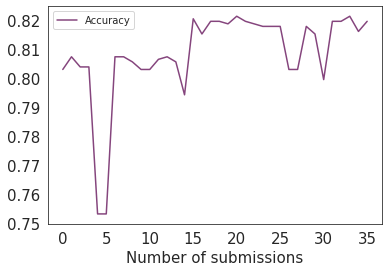

In [80]:
df_accuracy.plot(y = "Accuracy", fontsize = 15, color = [(0.52, 0.27, 0.49)])
plt.xlabel('Number of submissions', fontsize = 15)